<a href="https://colab.research.google.com/github/mchchoi/factorization/blob/main/LiftedMH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<>:171: SyntaxWarning: invalid escape sequence '\p'
<>:172: SyntaxWarning: invalid escape sequence '\p'
<>:173: SyntaxWarning: invalid escape sequence '\p'
<>:171: SyntaxWarning: invalid escape sequence '\p'
<>:172: SyntaxWarning: invalid escape sequence '\p'
<>:173: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-1136031605.py:171: SyntaxWarning: invalid escape sequence '\p'
  hist_with_pi(Q_chain[burn:], "Histogram: Q vs $\pi^{(1)}$",r"$Q$")
/tmp/ipython-input-1136031605.py:172: SyntaxWarning: invalid escape sequence '\p'
  hist_with_pi(P_x_chain[burn:], "Histogram: P (x-marginal) vs $\pi^{(1)}$",r"$P$")
/tmp/ipython-input-1136031605.py:173: SyntaxWarning: invalid escape sequence '\p'
  hist_with_pi(P1_chain[burn:], "Histogram: $P^{(1)}$ vs $\pi^{(1)}$",r"$P^{(1)}$")


Q: acceptance rate (state-changes only) = 0.4989
P: move counts over T-1 steps: {'Q': 249885, 'drift': 249714, 'flip': 500400}


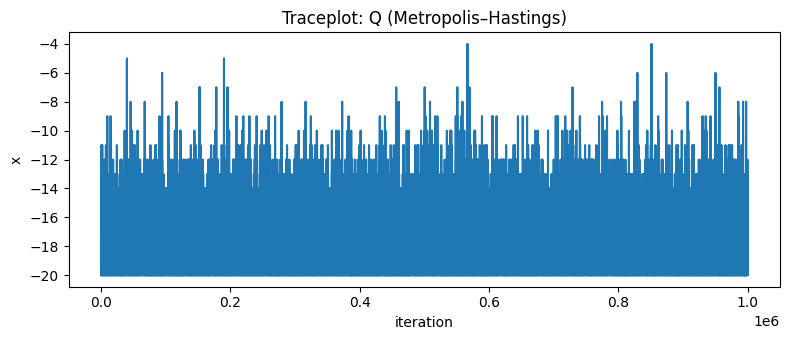

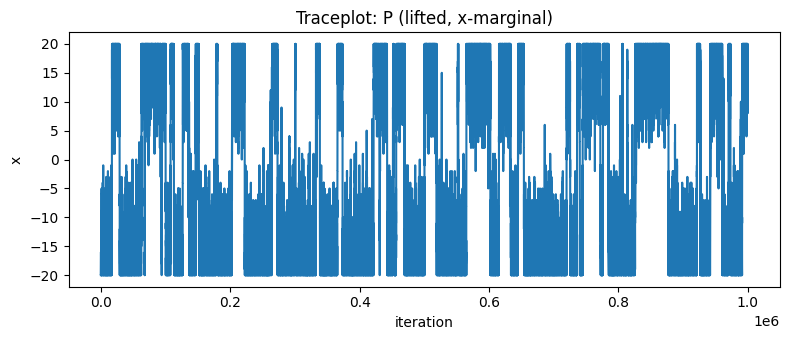

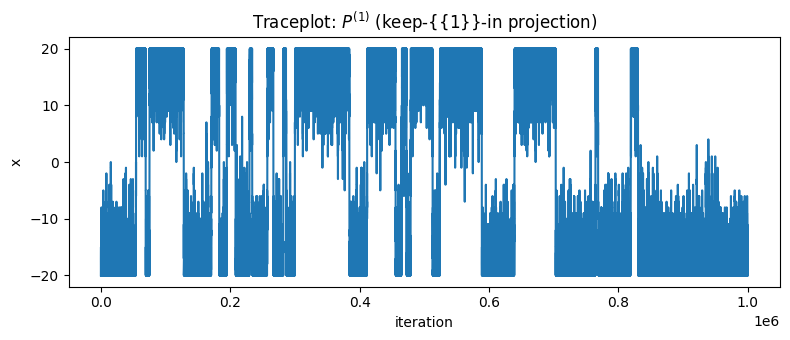

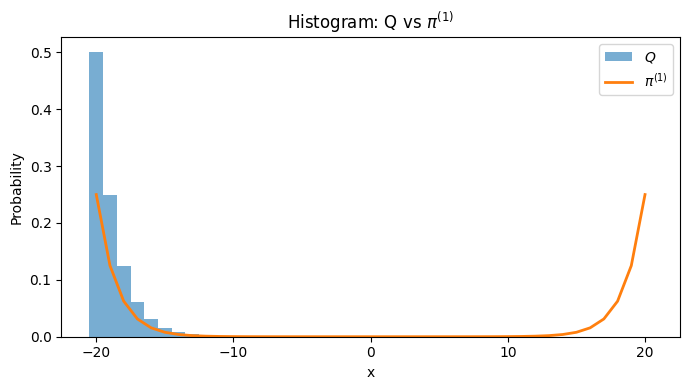

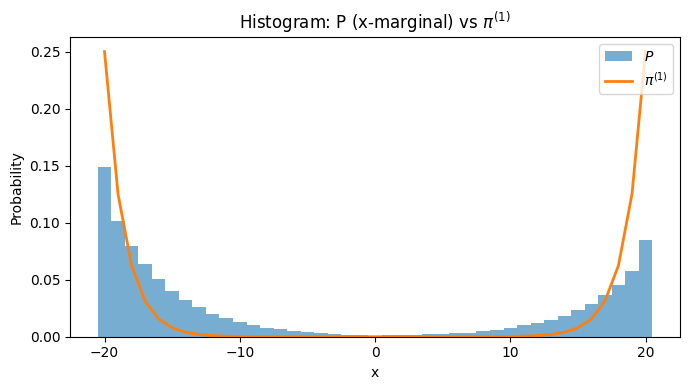

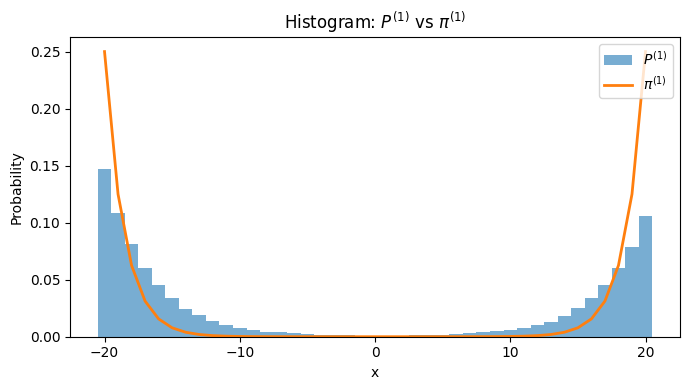


Empirical Mean & Second Moment vs Truth:
            Sampler       Mean  Second moment  ΔMean (emp - true)  ΔSecond (emp - true)
            Q (MH) -18.997193     362.930419          -18.997193             -0.069838
P (lifted, x-only)  -4.441998     284.808919           -4.441998            -78.191338
           P^{(1)}  -2.597562     301.074414           -2.597562            -61.925843
     Truth π^{(1)}   0.000000     363.000257            0.000000              0.000000


In [73]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Simulate and compare three MCMC samplers on a finite state space:
  Q  : Metropolis–Hastings on X^{(1)} = {-n, ..., n}
  P  : Lifted run-and-tumble sampler on X = X^{(1)} × {-1,+1}, with position moves via Q
  P1 : Keep-{1}-in projection sampler induced by one step of P after drawing v ~ Unif{-1,+1}

Target:
  π^{(1)}(x) ∝ 2^{|x|}, x ∈ {-n,...,n}

Proposal M (for Q):
  From x, propose y = clip(x + d) where d ∈ {-1,+1} uniformly. This implies
  M(x, y) = 1/2 if y = clip(x±1), and 0 otherwise.

Lifted kernel P parameters:
  With probability a: (x, v) -> (y, v) by applying a single Q step to x
  With probability b: (x, v) -> (clip(x+v), v)
  With probability c: (x, v) -> (x, -v)
  (Require a + b + c = 1)

P^{(1)} step:
  From x, draw v ~ Unif{-1,+1}; apply one P step to (x, v); return only the new position y.

Produces:
  - Trace plots (first trace_len iters) for Q, P (x only), and P^{(1)}
  - Histograms (post burn-in) overlaid with the true π^{(1)}

Usage:
  python sim_lifted_projection_mcmc.py
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Dict

# ---------------------- Configuration ----------------------
SEED = 12240
#11240
#10240
rng = np.random.default_rng(SEED)

n = 20                                  # state space is {-n, ..., n}
a = 1/4                                  # probability of Q-move inside P
b = 1/4                                  # probability of deterministic move along v
c = 1/2                                  # probability of flipping v

T = 1000000                                # total iterations per chain
burn = 1                              # burn-in for histograms
trace_len = 1000000                         # how many iterations to show in trace plot

# ---------------------- Target and helpers ----------------------
xs = np.arange(-n, n+1)

# Unnormalized target weights w(x) = 2^{|x|}
w = np.array([2**abs(x) for x in xs], dtype=np.float64)
pi = w / w.sum()                         # normalized π^{(1)}
w_lookup: Dict[int, float] = {int(x): float(2**abs(x)) for x in xs}

def clip_state(x: int) -> int:
    return int(np.clip(x, -n, n))

def M_prob(x: int, y: int) -> float:
    """Proposal probability M(x,y): y = clip(x±1) with prob 1/2; 0 otherwise."""
    if y == clip_state(x + 1) or y == clip_state(x - 1):
        return 0.5
    return 0.0

def propose_M(x: int) -> int:
    d = 1 if rng.random() < 0.5 else -1
    return clip_state(x + d)

def mh_step_Q(x: int) -> Tuple[int, bool]:
    """One MH step under Q with proposal M and target π^{(1)} ∝ w.
    Returns (new_x, accepted_move_that_changed_state)."""
    y = propose_M(x)
    num = w_lookup[y] * M_prob(y, x)
    den = w_lookup[x] * M_prob(x, y)
    alpha = 1.0 if num >= den else (num / den)
    if rng.random() < alpha:
        accepted = (y != x)
        return y, accepted
    else:
        return x, False

def p_step(x: int, v: int):
    """One step of lifted P. Returns (x_new, v_new, which_move)."""
    u = rng.random()
    if u < a:
        x_new, _ = mh_step_Q(x)
        return x_new, v, 'Q'
    elif u < a + b:
        x_new = clip_state(x + v)
        return x_new, v, 'drift'
    else:
        return x, -v, 'flip'

def p1_step(x: int) -> int:
    v = 1 if rng.random() < 0.5 else -1
    x_new, _v_new, _which = p_step(x, v)
    return x_new

# ---------------------- Simulate the three chains ----------------------
def simulate_Q(x0: int):
    chain = np.empty(T, dtype=int)
    chain[0] = x0
    accepts_changed = 0
    for t in range(1, T):
        chain[t], acc = mh_step_Q(chain[t-1])
        accepts_changed += int(acc)
    acc_rate_changed = accepts_changed / (T - 1)
    return chain, acc_rate_changed

def simulate_P(x0: int, v0: int):
    x_chain = np.empty(T, dtype=int)
    v_chain = np.empty(T, dtype=int)
    x_chain[0], v_chain[0] = x0, v0
    move_counts = {'Q': 0, 'drift': 0, 'flip': 0}
    for t in range(1, T):
        x_new, v_new, which = p_step(x_chain[t-1], v_chain[t-1])
        x_chain[t], v_chain[t] = x_new, v_new
        move_counts[which] += 1
    return x_chain, v_chain, move_counts

def simulate_P1(x0: int):
    chain = np.empty(T, dtype=int)
    chain[0] = x0
    for t in range(1, T):
        chain[t] = p1_step(chain[t-1])
    return chain

# ---------------------- Run ----------------------
if __name__ == "__main__":
    x0 = -20
    v0 = 1 if rng.random() < 0.5 else -1

    Q_chain, Q_acc_rate = simulate_Q(x0)
    P_x_chain, P_v_chain, P_move_counts = simulate_P(x0, v0)
    P1_chain = simulate_P1(x0)

    print("Q: acceptance rate (state-changes only) =", round(Q_acc_rate, 4))
    print("P: move counts over T-1 steps:", P_move_counts)

    def traceplot(chain: np.ndarray, title: str):
        plt.figure(figsize=(8, 3.5))
        plt.plot(np.arange(min(trace_len, len(chain))), chain[:trace_len])
        plt.xlabel("iteration")
        plt.ylabel("x")
        plt.title(title)
        plt.tight_layout()
        plt.show()

    traceplot(Q_chain, "Traceplot: Q (Metropolis–Hastings)")
    traceplot(P_x_chain, "Traceplot: P (lifted, x-marginal)")
    traceplot(P1_chain, "Traceplot: $P^{(1)}$ (keep-{{1}}-in projection)")

    bins = np.arange(-n - 0.5, n + 1.5, 1.0)

    def hist_with_pi(samples: np.ndarray, title: str,emp_label: str):
        plt.figure(figsize=(7, 4))
        plt.hist(samples, bins=bins, density=True, alpha=0.6, label=emp_label)
        plt.plot(xs, pi, linewidth=2, label=r"$\pi^{(1)}$")
        plt.xlabel("x")
        plt.ylabel("Probability")
        plt.title(title)
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.show()

    hist_with_pi(Q_chain[burn:], "Histogram: Q vs $\pi^{(1)}$",r"$Q$")
    hist_with_pi(P_x_chain[burn:], "Histogram: P (x-marginal) vs $\pi^{(1)}$",r"$P$")
    hist_with_pi(P1_chain[burn:], "Histogram: $P^{(1)}$ vs $\pi^{(1)}$",r"$P^{(1)}$")

# ---------------------- Table: empirical mean & second moment vs truth ----------------------
def summarize_mean_second(samples: np.ndarray):
  samples = samples.astype(float)
  m1 = float(np.mean(samples))
  m2 = float(np.mean(samples**2))
  return m1, m2

S_Q  = Q_chain[burn:]
S_Px = P_x_chain[burn:]
S_P1 = P1_chain[burn:]

mu_true     = float(np.sum(xs * pi))
second_true = float(np.sum((xs**2) * pi))

m1_Q, m2_Q   = summarize_mean_second(S_Q)
m1_P, m2_P   = summarize_mean_second(S_Px)
m1_P1, m2_P1 = summarize_mean_second(S_P1)

df_mom = pd.DataFrame([
      ["Q (MH)",             m1_Q,  m2_Q,  m1_Q  - mu_true,  m2_Q  - second_true],
      ["P (lifted, x-only)", m1_P,  m2_P,  m1_P  - mu_true,  m2_P  - second_true],
      ["P^{(1)}",            m1_P1, m2_P1, m1_P1 - mu_true,  m2_P1 - second_true],
      ["Truth π^{(1)}",      mu_true, second_true, 0.0, 0.0],
    ], columns=["Sampler", "Mean", "Second moment", "ΔMean (emp - true)", "ΔSecond (emp - true)"]).round(6)

print("\nEmpirical Mean & Second Moment vs Truth:\n", df_mom.to_string(index=False))
#df_mom.to_csv("empirical_mean_second_moment.csv", index=False)



In [74]:
def empirical_pmf(samples: np.ndarray, support: np.ndarray) -> np.ndarray:
    counts = np.bincount(samples - support[0], minlength=len(support))
    return counts / counts.sum()

def tv_dist(p, q): return 0.5 * np.abs(p - q).sum()

def kl_div(p, q):
    mask = p > 0
    return float(np.sum(p[mask] * (np.log(p[mask]) - np.log(q[mask]))))

def all_metrics(p_emp, p_true, support):
    return dict(
        TV = tv_dist(p_emp, p_true),
        KL_emp_true = kl_div(p_emp, p_true),
    )

p_Q  = empirical_pmf(S_Q,  xs)
p_P  = empirical_pmf(S_Px, xs)
p_P1 = empirical_pmf(S_P1, xs)

rows = []
for name, p_emp in [("Q (MH)", p_Q), ("P (lifted, x-only)", p_P), ("P^{(1)}", p_P1)]:
  met = all_metrics(p_emp, pi, xs)
  met["Sampler"] = name
  rows.append(met)

df_met = pd.DataFrame(rows)[["Sampler","TV","KL_emp_true"]].round(6)
print("\nHistogram vs Truth Metrics:\n", df_met.to_string(index=False))
#df_met.to_csv("hist_vs_truth_metrics.csv", index=False)



Histogram vs Truth Metrics:
            Sampler       TV  KL_emp_true
            Q (MH) 0.500003     0.693204
P (lifted, x-only) 0.374161     0.812290
           P^{(1)} 0.312679     0.534128
